## **Denoising Diffusion Probabilistic Models (DDPM)**

Let's build all elements of Diffusion model one-by-one, starting with U-Net Model

**1. UNet Model:**
Modified Implementation of UNet is used which includes:
*   Swish Activation function
*   Time step Embedding
*   Residual blocks
*   MultiHead Attention


* Code reference is taken from https://nn.labml.ai/diffusion/ddpm/index.html but it is rewritten from scratch for experiment and learning purpose

A) Swish Activation Function:

With ReLU, the consistent problem is that its derivative is 0 for half of the values of the input x. 

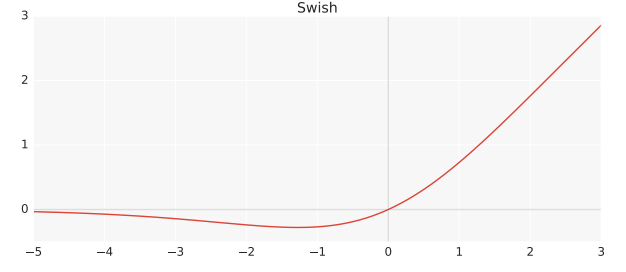

Swish is similar to Relu and a smooth, non-monotonic function that consistently matches or outperforms ReLU. 

In [1]:
### Import Libraries
import glob
import math
from typing import Optional, Tuple, Union, List
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np
import torch.nn.functional as F
from scipy import linalg
import os
from labml import lab, tracker, experiment, monit
import pandas as pd
import seaborn as sns
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.cuda.set_per_process_memory_fraction(0.2, 0)
torch.cuda.empty_cache()

In [2]:
class Swish(nn.Module):
  def forward(self,x):
    return x * torch.sigmoid(x)

B) Time Step Embedding:

We want to provide time step information to the model along with the input image data. However, labelling time step index as 1,2,3...so on can lead to large number and may hurt generalization of our model.

Proposed sinusoidal embedding represent the time as not a single number but a d-dimensional vector.

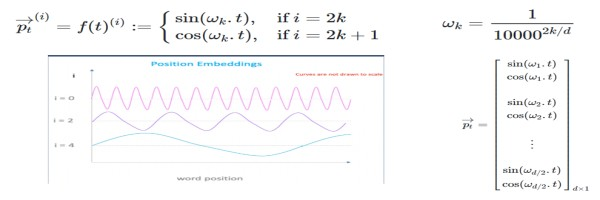


The frequencies are decreasing along the vector dimension.Imagine the positional embedding as a vector containing pairs of sines and cosines for each frequency. It is similar to binary representation of the number where LSB bit alternate on every number and second lowest bit is rotating on every two numbers. Here Sinusoidal functions are equivalent to alternating bits and there is decrease in frequency along the vector dimension.

In [3]:
class TimeEmbedding(nn.Module):
  def __init__(self,n_channels:int):
    super().__init__()
    self.n_channels = n_channels
    self.lin1 = nn.Linear(self.n_channels//4,self.n_channels)
    self.act = Swish()
    self.lin2 = nn.Linear(self.n_channels,self.n_channels)

  def forward(self,t:torch.tensor):

    ## creating sinusoidal embedding
    half_dim = self.n_channels//8
    emb = math.log(10_000)/(half_dim-1)
    emb = torch.exp(torch.arange(half_dim,device=t.device)*-emb)
    emb = t[:,None] * emb[None,:]
    emb = torch.cat((emb.sin(),emb.cos()),dim=1)
    ## Transform with MLP
    emb = self.act(self.lin1(emb))
    emb = self.lin2(emb)
    return emb


### Label Embedding - converting n_classes vector to n_channels embedding
class LabelEmbedding(nn.Module):
  def __init__(self,n_classes:int, n_channels:int):
    super().__init__()
    self.n_classes = n_classes
    self.n_channels = n_channels
    self.lin1 = nn.Linear(self.n_classes,self.n_channels)
    self.act = Swish()
    self.lin2 = nn.Linear(self.n_channels,self.n_channels)

  def forward(self,t:torch.tensor):

    emb = self.act(self.lin1(t))
    emb = self.lin2(emb)
    return emb

C) Residual Block:

A residual block has two convolution layers with group normalization. Each resolution is processed with two residual blocks.

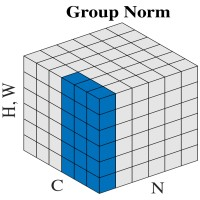

Group Normalization is a normalization layer that divides channels into groups and normalizes the features within each group. GN does not exploit the batch dimension, and its computation is independent of batch sizes. In the case where the group size is 1, it is equivalent to Instance Normalization.


In [4]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
    super().__init__()

    self.norm1 = nn.GroupNorm(n_groups, in_channels)
    self.act1 = Swish()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size =(3, 3), padding =(1, 1))

    self.norm2 = nn.GroupNorm(n_groups, out_channels)
    self.act2 = Swish()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size =(3, 3), padding =(1, 1))
    
    if in_channels != out_channels:
      self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size = (1,1))
    else:
      self.shortcut = nn.Identity()

    self.time_emb = nn.Linear(time_channels, out_channels)

  def forward(self, x: torch.Tensor, t:torch.Tensor):
    h = self.conv1(self.act1(self.norm1(x)))
    h += self.time_emb(t)[:,:,None,None]
    h = self.conv2(self.act2(self.norm2(h)))
    return h + self.shortcut(x)

D) Attention Block

This is transformer multi-head attention 

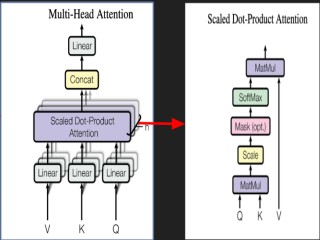

In [5]:
class AttentionBlock(nn.Module):
  def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
    super().__init__()
    if d_k is None:
      d_k = n_channels
    
    ## Normalization Layer
    self.norm = nn.GroupNorm(n_groups, n_channels)

    ## Projections for query, key, values
    self.projection = nn.Linear(n_channels, n_heads * d_k * 3)

    ## Linear layer for transformation
    self.output = nn.Linear(n_heads* d_k, n_channels)

    self.scale = d_k ** -0.5
    self.n_heads = n_heads
    self.d_k = d_k
 
  def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
    
    _ = t

    batch_size, n_channels, height, width = x.shape
    x = x.view(batch_size, n_channels, -1).permute(0,2,1)

    ## Linear Projection
    qkv = self.projection(x).view(batch_size,-1,self.n_heads, 3*self.d_k)
    
    ## Get Q,K,V
    q,k,v = torch.chunk(qkv, 3, dim=-1)
    
    ## MatMul & Scale
    attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
    
    ## Softmax
    attn = attn.softmax(dim=2)
    
    ## Multiply by Value
    res = torch.einsum('bijh,bjhd->bihd', attn, v)
    
    ## Concat & Linear transform
    res = res.view(batch_size, -1, self.n_heads * self.d_k)
    res = self.output(res)
    res += x
    res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)
    return res

E) Down Block:


This combines ResidualBlock and AttentionBlock . These are used in the first half of U-Net at each resolution.

F) Up Block:

This combines ResidualBlock and AttentionBlock . These are used in the second half of U-Net at each resolution.

G) Middle Block:

It combines a ResidualBlock , AttentionBlock , followed by another ResidualBlock . This block is applied at the lowest resolution of the U-Net.



In [6]:
class DownBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn):
    super().__init__()

    self.res = ResidualBlock(in_channels, out_channels, time_channels)
    if has_attn:
      self.attn = AttentionBlock(out_channels)
    else:
      self.attn = nn.Identity()

  def forward(self, x: torch.Tensor, t: torch.Tensor):
    x = self.res(x,t)
    x = self.attn(x)
    return x

In [7]:
class UpBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
    super().__init__()
    self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
    if has_attn:
      self.attn = AttentionBlock(out_channels)
    else:
      self.attn = nn.Identity()

  def forward(self, x: torch.Tensor, t:torch.Tensor):
    x = self.res(x,t)
    x = self.attn(x)
    return x

class MiddleBlock(nn.Module):
  def __init__(self, n_channels:int, time_channels:int):
    super().__init__()
    self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
    self.attn = AttentionBlock(n_channels)
    self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

  def forward(self, x: torch.Tensor, t:torch.Tensor):
    x = self.res1(x,t)
    x = self.attn(x)
    x = self.res2(x,t)
    return x

class Upsample(nn.Module):
  def __init__(self, n_channels):
    super().__init__()
    self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4,4), (2,2), (1,1))
  
  def forward(self, x:torch.Tensor, t:torch.Tensor):
    _ = t
    return self.conv(x)
  
class Downsample(nn.Module):
  def __init__(self, n_channels):
    super().__init__()
    self.conv = nn.Conv2d(n_channels, n_channels, (3,3), (2,2), (1,1))
  
  def forward(self, x:torch.Tensor, t:torch.Tensor):
    _ = t
    return self.conv(x)
  


### UNet Model:

This is a U-Net based model to predict noise ϵθ(xt,t).


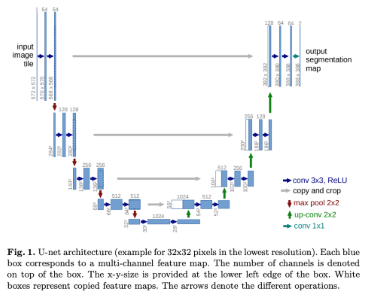

U-Net is a gets it's name from the U shape in the model diagram. It processes a given image by progressively lowering (halving) the feature map resolution and then increasing the resolution. There are pass-through connection at each resolution. This implementation contains a bunch of modifications to original U-Net (residual blocks, multi-head attention) and also adds time-step embeddings t.


In [8]:
class UNet(nn.Module):
  def __init__(self, image_channels: int = 3, n_channels: int = 64,
               ch_mults: Union[Tuple[int, ...], List[int]] = (1,2,2,4),
               is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
               n_blocks: int = 2, n_classes: int = None):
    super().__init__()
    
    ## number of resolutions
    n_resolutions = len(ch_mults)

    ## Mapping to feature space
    self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3,3), padding = (1,1))
    self.time_emb = TimeEmbedding(n_channels * 4)
    
    self.n_classes = n_classes
    if n_classes is not None:
        self.label_emb = LabelEmbedding(self.n_classes,n_channels*4)
    else:
        n_classes = None
    ## BUilding Down block
    down = []
    out_channels = in_channels = n_channels

    for i in range(n_resolutions):
      out_channels = in_channels * ch_mults[i]

      for _ in range(n_blocks):
        down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
        in_channels = out_channels

      if i < n_resolutions - 1:
        down.append(Downsample(in_channels))
  
    self.down = nn.ModuleList(down)
    self.middle = MiddleBlock(out_channels,n_channels*4,)

    ## Building Up block
    up = []
    in_channels = out_channels

    for i in reversed(range(n_resolutions)):
      out_channels = in_channels
      for _ in range(n_blocks):
        up.append(UpBlock(in_channels, out_channels, n_channels*4, is_attn[i]))

      out_channels = in_channels // ch_mults[i]
      up.append(UpBlock(in_channels, out_channels, n_channels *4 , is_attn[i]))
      in_channels = out_channels

      if i > 0:
        up.append(Upsample(in_channels))

    self.up = nn.ModuleList(up)

    ## Final Normlization & Conv layer
    self.norm = nn.GroupNorm(8, n_channels)
    self.act = Swish()
    self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3,3), padding = (1,1))

  def forward(self, x :torch.Tensor, t:torch.Tensor, y: torch.Tensor=None):
    t = self.time_emb(t)
    x = self.image_proj(x)
    if self.n_classes is not None:
        assert (y.shape[0],) == (x.shape[0],)
        t = t + self.label_emb(y)
    
    h = [x]
    for m in self.down:
      x = m(x,t)
      h.append(x)
    
    x = self.middle(x,t)

    for m in self.up:
      if isinstance(m,Upsample):
        x = m(x,t)
      else:
        s = h.pop()
        x = torch.cat((x,s),dim=1)
        x = m(x,t)
    return self.final(self.act(self.norm(x)))

### Diffusion Probabilistic Model:

Lets formulate Forward, Reverse and loss implementation oF DDPM


In [9]:
def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""

    ## Gathers values along an axis specified by dim.
    # t = torch.tensor([[1, 2], [3, 4]])
    # torch.gather(t, 1, torch.tensor([[0, 0], [1, 0]])) -> tensor [[1,1],[4,3]]
    ## Gather along axis 1 -> rows,and indexed by tensor
    
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

In [10]:
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model

        ## Creating B1,B1,..BT linearly increasing variance schedule
        self.beta = torch.linspace(0.0001,0.02,n_steps).to(device)

        self.alpha = 1- self.beta
        self.alpha_bar = torch.cumprod(self.alpha,dim = 0)
        self.n_steps = n_steps
        self.sigma2 = self.beta


    ## Forward q(xt|xo)
    def q_xt_x0(self, x0: torch.tensor, t:torch.Tensor) -> Tuple[torch.Tensor,torch.Tensor]:
        mean = gather(self.alpha_bar,t) ** 0.5 * x0
        var = 1 - gather(self.alpha_bar,t)
        return mean,var

    ## Sample from q(xt|xo)
    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor]=None):
        if eps is None:
            eps = torch.randn_like(x0)

        mean,var = self.q_xt_x0(x0,t)
        return mean + (var**0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor, label:Optional[torch.Tensor] = None):
        eps_theta = self.eps_model(xt,t,label)
        alpha_bar = gather(self.alpha_bar,t)
        alpha = gather(self.alpha,t)
        eps_coef = (1-alpha)/(1-alpha_bar)**0.5
        mean = 1/(alpha**0.5) * (xt - eps_coef* eps_theta)
        var = gather(self.sigma2,t)
        eps = torch.randn(xt.shape, device = xt.device)
        return mean + (var ** 0.5) * eps
  
    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None,label: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device= x0.device, dtype=torch.long)
        if noise is None:
            noise = torch.randn_like(x0)
            
        xt = self.q_sample(x0,t,eps=noise)
        eps_theta = self.eps_model(xt,t,label)
        return nn.functional.mse_loss(noise, eps_theta)

### Dataset Loader

###### Change the Image filepaths for your use

In [11]:
## BitMoji  Dataset
class BitMojiDataset(torch.utils.data.Dataset):
    """
    ### BitMoji HQ dataset
    """

    def __init__(self, image_size: int):
        super().__init__()

        # CelebA images folder
        folder = "data/bitmojis/"
#         folder = "../input/mnistasjpg/"
        # List of files
        self._files = glob.glob(folder +"*.png")

        # Transformations to resize the image and convert to tensor
        self._transform = transforms.Compose([
            transforms.Resize((image_size,image_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        """
        Size of the dataset
        """
        return len(self._files)

    def __getitem__(self, index: int):
        """
        Get an image
        """
        img = Image.open(self._files[index])
        return self._transform(img)

## CELEBA A Dataset
class CelebADataset(torch.utils.data.Dataset):
    """
    ### CelebA HQ dataset
    """

    def __init__(self, image_size: int, n_classes:int = None):
        super().__init__()

        # CelebA images folder
        folder = "../VAE/data/celeba/img_align_celeba/"
        self._files = glob.glob(folder +"*.jpg")

        # Transformations to resize the image and convert to tensor
        self._transform = transforms.Compose([
            transforms.Resize((image_size,image_size)),
            transforms.ToTensor(),
        ])
        
        self.n_classes = n_classes
        if self.n_classes is not None:
            data = pd.read_csv("../VAE/data/celeba/list_attr_celeba.csv")
            self.cols = ['image_id','Bald', 'Black_Hair', 'Blond_Hair','Brown_Hair','Eyeglasses','Male','Smiling','Mustache','No_Beard','Young']
            self.labels = data[self.cols]
        

    def __len__(self):
        """
        Size of the dataset
        """
        return len(self._files)

    def __getitem__(self, index: int):
        """
        Get an image
        """
        if self.n_classes is not None:
            file = self._files[index]
            img = Image.open(file)
            token = file.split("/")[-1]
            y_true = self.labels[self.labels["image_id"] == token][self.cols[1:]].values.tolist()[0]
            return self._transform(img),torch.FloatTensor(y_true)
        else:
            img = Image.open(self._files[index])
            return self._transform(img)
        

## Train & sample loop

In [12]:
def train():
  for data in monit.iterate("Train",train_dataloader):
    tracker.add_global_step()
    if n_classes is not None:
        xdata = data[0].to(device)
        ydata = data[1].to(device)
    else:
        xdata = data.to(device)
        ydata = None
        
    optimizer.zero_grad()
    loss = diffusion.loss(xdata,label = ydata)
    loss.backward()
    optimizer.step()
    tracker.save("loss",loss)

def sample():
    with torch.no_grad():
        x = torch.randn([n_samples, image_channels,image_size, image_size], device = device)
        for t_ in monit.iterate('Sample',n_steps):
          t = n_steps - t_ - 1
          x = diffusion.p_sample(x, x.new_full((n_samples,), t, dtype=torch.long))
    return x

def run():
  for _ in monit.loop(epochs):
    train()
    tracker.new_line()
    experiment.save_checkpoint()

### Initialize configs

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

image_channels: int = 3
image_size: int = 32
n_channels: int = 64
n_steps = 1_000
batch_size = 8
learning_rate = 2e-5
channel_multipliers: List[int] = [1, 2, 2, 4]
is_attention: List[int] = [False, False, False, True]
epochs = 10
n_samples = 16

## if non conditional, put n_classes = None else specify the number of class:usually 10
n_classes = 10 #or None
# n_classes=None

cuda


#### Get CelebA & BitMoji Dataset 

In [14]:
train_dataloader = DataLoader(dataset=CelebADataset(image_size,n_classes), batch_size = batch_size, shuffle=True,num_workers=2)
train_dataloader1 = DataLoader(dataset=BitMojiDataset(image_size), batch_size = batch_size, shuffle=True,num_workers=2)

#### Get Model

In [15]:
model = UNet(image_channels = image_channels, n_channels= n_channels,
            ch_mults=channel_multipliers, is_attn=is_attention,n_classes=n_classes).to(device)
diffusion = DenoiseDiffusion(model, n_steps, device = device)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

#### Run Experiment

In [ ]:
experiment.create(name="diffuse",writers = {'screen','labml'})
experiment.configs({
    'dataset':'BitMoji',
    'image_channels': image_channels,
    'image_size': image_size,
    'n_channels': n_channels,
    'batch_size': batch_size,
    'n_steps': n_steps,
    'learning_rate': learning_rate,
    'epochs': epochs,
    'n_samples':n_samples,
    'n_classes':n_classes,
})
experiment.add_pytorch_models({'model':model})
with experiment.start():
  run()

# FID Calculations

In [ ]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    out = []
    for i in range(len(images)//20):
        out.append(inceptionModel(batch[(i*20):(i+1)*20].to("cuda"))[0])
    pred= torch.vstack(out)
    print("Done")
        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

#### Generate 1000 real samples

In [ ]:
n_samples = 1000
batch_size = 1000
n_steps = 1000
train_dataloader = DataLoader(dataset=CelebADataset(image_size,n_classes), batch_size = batch_size, shuffle=True,num_workers=2)
it = iter(train_dataloader)
real = it.next()[0].to("cuda")

#### Generate 1000 fake samples

In [ ]:
n_samples = 1000
n_steps = 1000
file = "logs/models/celeba/model.pth"
model = UNet(image_channels = image_channels, n_channels= n_channels,
        ch_mults=channel_multipliers, is_attn=is_attention,n_classes=n_classes).to(device)
model.load_state_dict(torch.load(file))
diffusion = DenoiseDiffusion(model, n_steps, device = device)
fake = sample()

#### Calculating fretchet distance

In [ ]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inceptionModel = InceptionV3([block_idx])
inceptionModel=inceptionModel.cuda()
fretchet_dist=calculate_fretchet(real,fake,inceptionModel)
print(fretchet_dist)

# Results

#### FID results on celebA Dataset

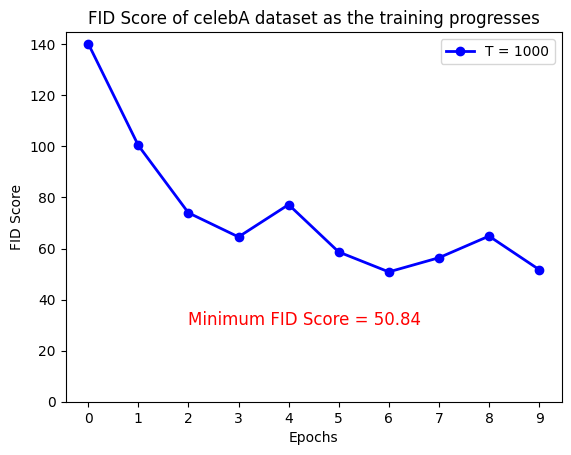

In [8]:
celebA_1000 = np.load("./logs/results/celeba_1000.npy")
itertn = np.array([int(celebA_1000[i,0].split("/")[-2]) for i in range(len(celebA_1000[:,0]))])
fid =np.array([float(celebA_1000[i,1]) for i in range(len(celebA_1000[:,0]))])
plt.plot(np.arange(len(fid)),fid[np.argsort(itertn)],"o-",color="blue",linewidth =2,label="T = 1000")
plt.legend()
plt.ylim(0,)
plt.xticks(np.arange(10))
plt.xlabel("Epochs")
plt.ylabel("FID Score")
plt.title("FID Score of celebA dataset as the training progresses")
plt.text(2,30,"Minimum FID Score = 50.84",fontsize=12,color="red")

plt.show()

#### FID result on bitmoji dataset

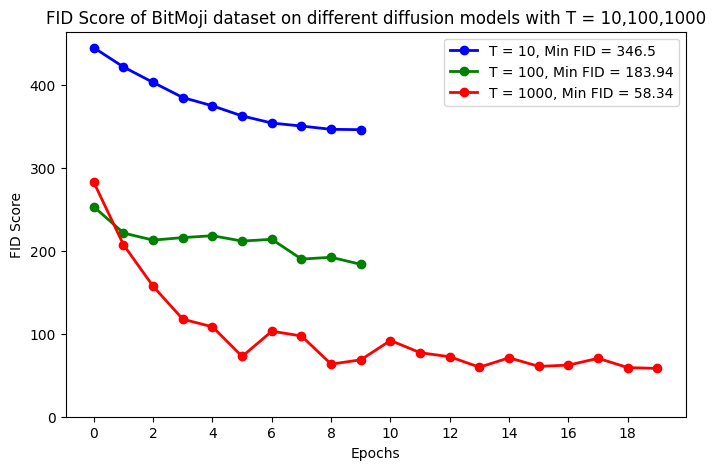

In [11]:
fig = plt.figure(figsize=(8,5))
bitmoji_10 = np.load("./logs/results/bitmoji_10.npy")
itertn = np.array([int(bitmoji_10[i,0].split("/")[-2]) for i in range(len(bitmoji_10[:,0]))])
fid =np.array([float(bitmoji_10[i,1]) for i in range(len(bitmoji_10[:,0]))])
plt.plot(np.arange(len(fid)),fid[np.argsort(itertn)],"o-",color="blue",linewidth =2,label="T = 10, Min FID = " + str(round(np.min(fid),2)))

bitmoji_100 = np.load("./logs/results/bitmoji_100.npy")
itertn = np.array([int(bitmoji_100[i,0].split("/")[-2]) for i in range(len(bitmoji_100[:,0]))])
fid =np.array([float(bitmoji_100[i,1]) for i in range(len(bitmoji_100[:,0]))])
plt.plot(np.arange(len(fid)),fid[np.argsort(itertn)],"o-",color="green",linewidth =2,label="T = 100, Min FID = " + str(round(np.min(fid),2)))

bitmoji_1000 = np.load("./logs/results/bitmoji_1000.npy")
itertn = np.array([int(bitmoji_1000[i,0].split("/")[-2]) for i in range(len(bitmoji_1000[:,0]))])
fid =np.array([float(bitmoji_1000[i,1]) for i in range(len(bitmoji_1000[:,0]))])
plt.plot(np.arange(len(fid)),fid[np.argsort(itertn)],"o-",color="red",linewidth =2,label="T = 1000, Min FID = " + str(round(np.min(fid),2)))

plt.ylim(0,)
plt.xticks([0,2,4,6,8,10,12,14,16,18])
plt.xlabel("Epochs")
plt.ylabel("FID Score")
plt.title("FID Score of BitMoji dataset on different diffusion models with T = 10,100,1000")
plt.legend()
# plt.text(2.5,20,"Minimum FID Score = 58.34",fontsize=12,color="red")

plt.show()

#### Samples generated from diffusion model

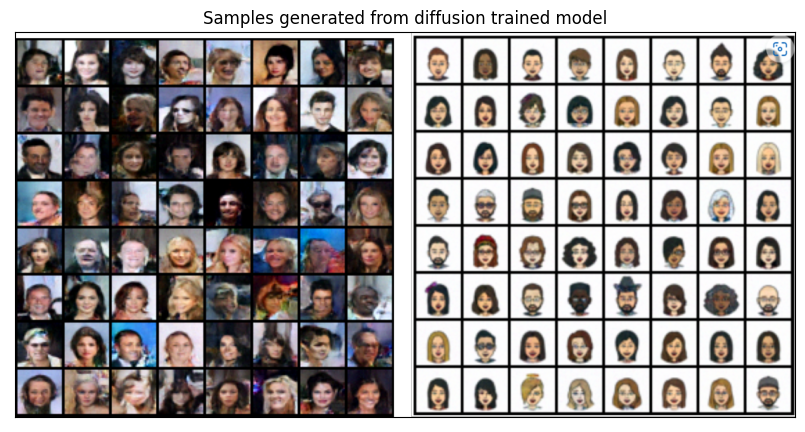

In [22]:
samples = plt.imread("./logs/results/diffusion_generated_output.png")
plt.figure(figsize=(12,5))
plt.imshow(samples)
plt.xticks([])
plt.yticks([])
plt.title("Samples generated from diffusion trained model")
plt.show()

### Generate 10 denoising steps

In [ ]:
## Load model
model = UNet(image_channels = image_channels, n_channels= n_channels,
            ch_mults=channel_multipliers, is_attn=is_attention,n_classes=n_classes).to(device)
model.load_state_dict(torch.load("logs/models/celeba/model.pth"))
n_steps = 1000
diffusion = DenoiseDiffusion(model, n_steps, device = device)

## Aggregated output from different time steps
n_samples = 10
bigArray = []
with torch.no_grad():
    x = torch.randn([n_samples, image_channels,image_size, image_size], device = device)
    for t_ in monit.iterate('Sample',n_steps):
        t = n_steps - t_ - 1
        x = diffusion.p_sample(x, x.new_full((n_samples,), t, dtype=torch.long))
        if t_ in [700,800,900,920,940,960,980,990,994,999]:    
            x1 = x.clip(0,1)
            x1 = x1.to("cpu").permute(0,2,3,1)
            bigArray.append(x1)

## Plot the output
plt.figure(figsize=(10,10))
plt.imshow(torch.stack(bigArray,axis = 2).reshape(320,320,3))
plt.xticks([])
plt.yticks([])
plt.show()

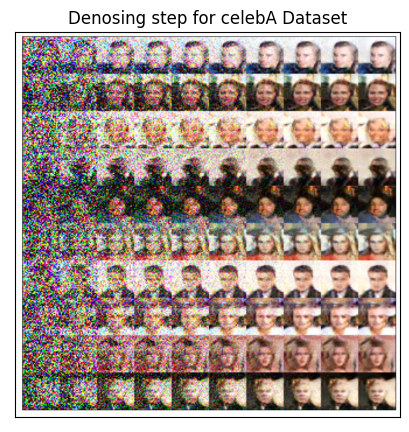

In [18]:
samples = plt.imread("./logs/results/denoising_step_celeba.png")
plt.figure(figsize=(15,5))
plt.imshow(samples)
plt.xticks([])
plt.yticks([])
plt.title("Denosing step for celebA Dataset")
plt.show()

## Generating class conditional output

#### For training class conditional diffusion model, specify n_classes = 10

* we selected 10 classes as 'Bald', 'Black_Hair', 'Blond_Hair','Brown_Hair','Eyeglasses','Male','Smiling','Mustache','No_Beard','Young'

* The groundtruth for these 10 classes is obtained from list_celeba_Attr_list.csv which has values -1 or 1 for every class.
* We pass these groundtruth values through label embedding which is 2 layer MLP network.
* Output from label embedding is simply added with time embedding and it is passed on to UNet network


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


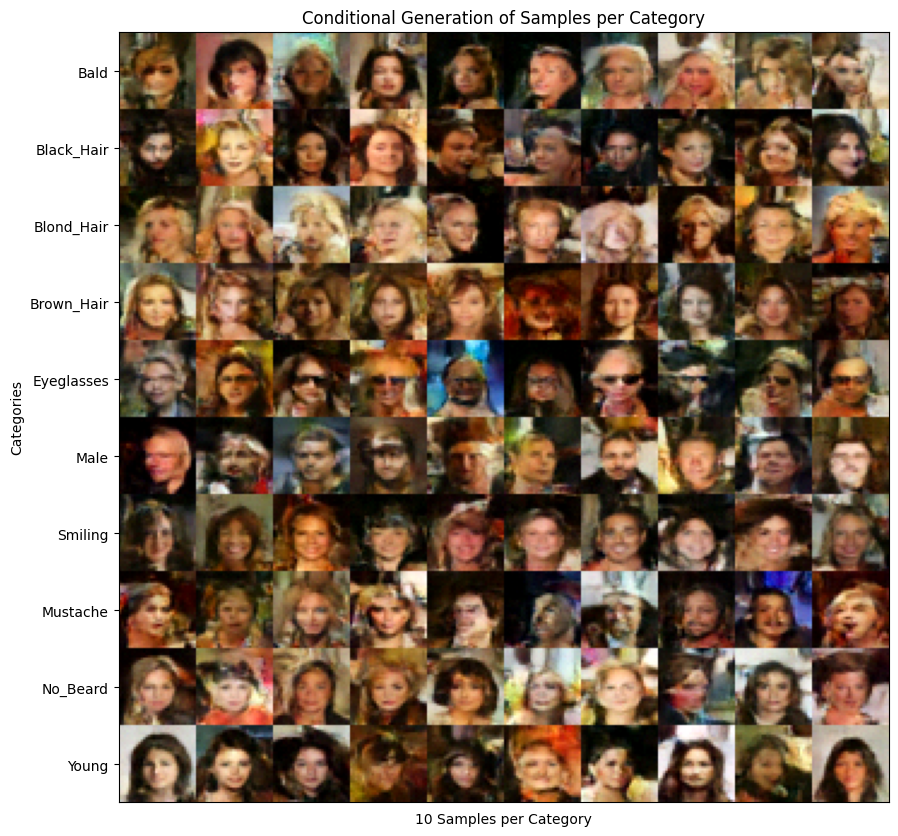

In [16]:
file = "logs/models/cond_celeba/model.pth"
n_classes = 10
model = UNet(image_channels = image_channels, n_channels= n_channels,
                ch_mults=channel_multipliers, is_attn=is_attention,n_classes=n_classes).to(device)
model.load_state_dict(torch.load(file))
diffusion = DenoiseDiffusion(model, n_steps, device = device)
n_samples = 10
genData = []

## Only one label is set 1 other as -1,similarly done for all the categories
for i in range(10):
    with torch.no_grad():
        x = torch.randn([n_samples, image_channels,image_size, image_size], device = device)
        label = torch.FloatTensor([[-1]*n_classes] * n_samples).to(device)
        label[:,i] = 1
        for t_ in monit.iterate('Sample',n_steps):
            t = n_steps - t_ - 1
            x = diffusion.p_sample(x, x.new_full((n_samples,), t, dtype=torch.long),label)
        genData.append(x)

plt.figure(figsize=(10,10))
plt.imshow(torch.stack(genData).permute(0,3,1,4,2).reshape(320,320,3).to("cpu"))
# plt.show()
plt.xticks([])
plt.yticks([16,48,80,112,144,176,208,240,272,304],['Bald', 'Black_Hair', 'Blond_Hair','Brown_Hair','Eyeglasses','Male','Smiling','Mustache','No_Beard','Young'])
plt.xlabel("10 Samples per Category")
plt.title("Conditional Generation of Samples per Category")
plt.ylabel("Categories")
plt.show()


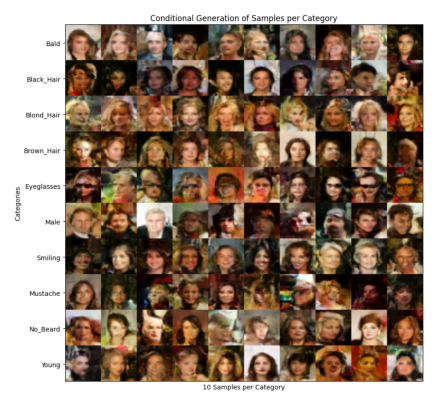

In [17]:
samples = plt.imread("./logs/results/cond_generation.png")
plt.figure(figsize=(20,5))
plt.imshow(samples)
plt.axis("off")
plt.show()